In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor

In [2]:
class MyRandomForest:
    
    def __init__(self, n_estimators= 100, k_frac= 0.25, max_depth= 10):
        self.n_estimators = n_estimators
        self.k_frac = 0.25
        self.max_depth = max_depth
        
    def fit(self, X, y):
        self.models = []
        self.inds = []
        self.objs = []
        for i in range(self.n_estimators):
            self.models.append(DecisionTreeRegressor(max_depth= self.max_depth))
            self.inds.append(np.random.choice(np.arange(X.shape[1]), round(X.shape[1] * self.k_frac), replace= False))
            self.objs.append(np.random.choice(np.arange(X.shape[0]), round(X.shape[0] * 0.6))) # 0.6 - оптимальный параметр из лекции
            self.models[-1].fit(X.drop(self.inds[-1], axis= 1).iloc[self.objs[-1], :], y[self.objs[-1]])
            
    def predict(self, X):
        pred = np.zeros(X.shape[0])
        for i in range(self.n_estimators):
            X_bagged = X.drop(self.inds[i], axis= 1)
            pred += self.models[i].predict(X_bagged)
        return pred / self.n_estimators

In [3]:
mrf = MyRandomForest()

In [4]:
from sklearn.datasets import make_classification

In [5]:
X, y = make_classification(n_samples= 1000, n_features= 4, n_informative= 3, n_redundant= 1)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 0)

In [8]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [9]:
X_train.index = np.arange(X_train.shape[0])
X_test.index = np.arange(X_test.shape[0])
X_train.columns = np.arange(X_train.shape[1])
X_test.columns = np.arange(X_test.shape[1])

In [10]:
mrf.fit(X_train, y_train)

In [11]:
pred = mrf.predict(X_test)

In [12]:
from sklearn.metrics import auc, roc_curve

In [13]:
fpr, tpr, threshold = roc_curve(y_test, pred)

In [14]:
auc(fpr, tpr)

0.9831932773109243

gutt

Эксперименты!

In [131]:
data = pd.read_csv('kc_house_data.csv')
data['date'] = data['date'].values.astype(str)
data['year'] = data['date'].str.slice(stop=4).astype(int)
data['month'] = data['date'].str.slice(4, 6).astype(int)
data['day'] = data['date'].str.slice(6, 8).astype(int)

In [134]:
y = np.array(data['price'])
X = data.drop(['price', 'date'], axis= 1)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 0, shuffle= True)

In [136]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [137]:
X_train.index = np.arange(X_train.shape[0])
X_test.index = np.arange(X_test.shape[0])
X_train.columns = np.arange(X_train.shape[1])
X_test.columns = np.arange(X_test.shape[1])

In [146]:
n_grid = [10, 25, 50, 100, 250, 500]

In [147]:
k_grid = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8]

In [148]:
depth_grid = [3, 5, 8, 12, 20, None]

In [149]:
tri_d_rmse = np.zeros((6, 6, 6))
tri_d_time = np.zeros((6, 6, 6))

In [150]:
from sklearn.metrics import mean_squared_error as mse
def rmse(X, y):
    return mse(X, y) ** (1 / 2)

In [151]:
from time import time

In [152]:
for n in range(len(n_grid)):
    for k in range(len(k_grid)):
        for d in range(len(depth_grid)):
            st_time = time()
            mrf = MyRandomForest(n_grid[n], k_grid[k], depth_grid[d])
            mrf.fit(X_train, y_train)
            pred = mrf.predict(X_test)
            tri_d_rmse[n, k, d] = rmse(y_test, pred)
            tri_d_time[n, k, d] = time() - st_time

In [153]:
# https://www.geeksforgeeks.org/3d-heatmap-in-python/

In [154]:
arr_n_rmse = [tri_d_rmse[i] for i in range(len(n_grid))]
arr_n_time = [tri_d_time[i] for i in range(len(n_grid))]

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

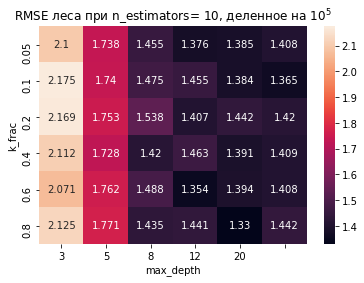

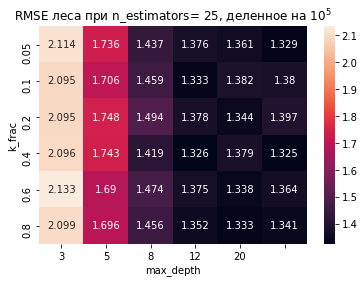

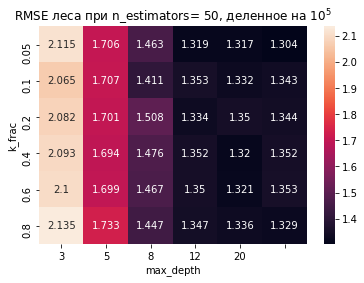

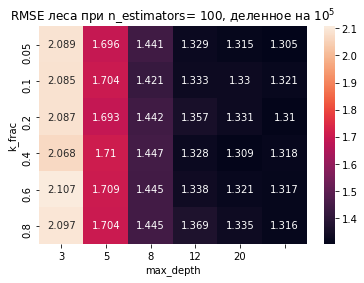

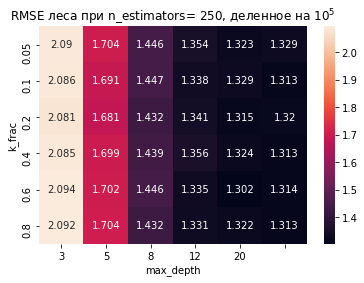

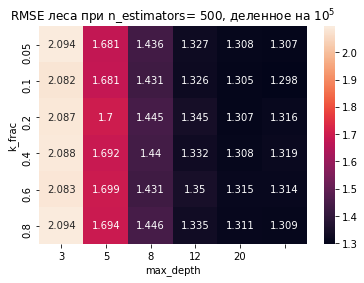

In [172]:
for i in range(len(n_grid)):
    df_hm = pd.DataFrame(arr_n_rmse[i] / 10 ** 5)
    df_hm.index = np.arange(len(n_grid))
    df_hm.index.names = ['k_frac']
    df_hm.columns = np.arange(len(n_grid))
    df_hm.columns.names = ['max_depth']
    sns.heatmap(df_hm, annot=True, yticklabels= k_grid, xticklabels= depth_grid, fmt ='.4g')
    plt.title('RMSE леса при n_estimators= ' + str(n_grid[i]) +', деленное на $10^5$')
    plt.savefig('ForestRMSE' + str(n_grid[i]) + '.pdf')
    plt.show()

In [165]:
tri_d_rmse[5, 1, 5]

129829.43795132353

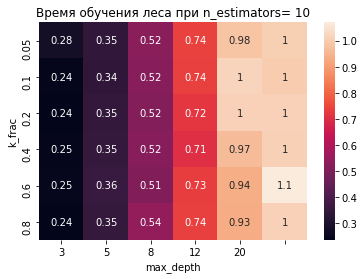

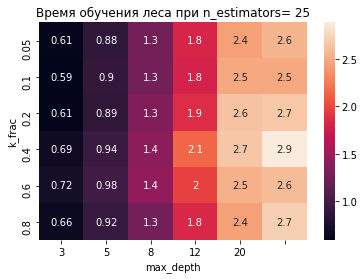

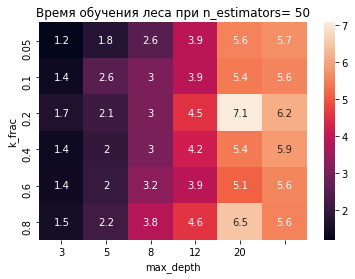

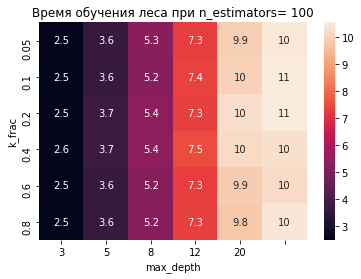

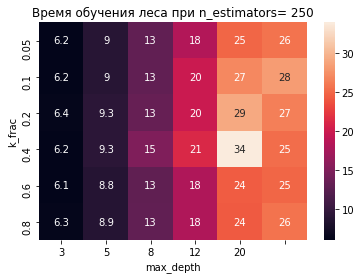

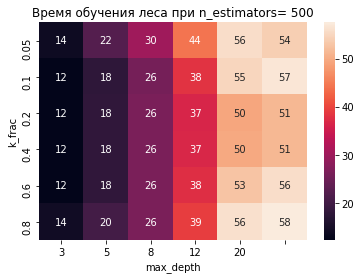

In [157]:
for i in range(len(n_grid)):
    df_hm = pd.DataFrame(arr_n_time[i])
    df_hm.index = np.arange(len(n_grid))
    df_hm.index.names = ['k_frac']
    df_hm.columns = np.arange(len(n_grid))
    df_hm.columns.names = ['max_depth']
    sns.heatmap(df_hm, annot=True, yticklabels= k_grid, xticklabels= depth_grid)
    plt.title('Время обучения леса при n_estimators= ' + str(n_grid[i]))
    plt.show()

In [205]:
import pickle

Лучшая модель - n_estimators=500, k_frac=0.1, max_depth=None.
Сохраним ее!

In [208]:
model = MyRandomForest(n_estimators=500, k_frac=0.1, max_depth=None)
model.fit(X_train, y_train)

In [209]:
filename = 'random_forest_best.sav'
pickle.dump(model, open(filename, 'wb'))

ГрадБуст!!!

In [173]:
n_grid = [10, 25, 50, 100, 250, 500]

In [174]:
k_grid = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8]

In [175]:
depth_grid = [3, 5, 8, 12, 20, None]

In [176]:
learning_grid = [0.025, 0.05, 0.1, 0.2, 0.5, 1]

In [178]:
class MyGradBoost:
    
    def __init__(self, n_estimators= 100, k_frac= 0.25, max_depth= 10, learning_rate= 0.1):
        self.n_estimators = n_estimators
        self.k_frac = k_frac
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        
    def fit(self, X, y):
        self.models = []
        pred = []
        # init first predictor
        self.models.append(DecisionTreeRegressor(max_depth= self.max_depth))
        self.models[-1].fit(X, y)
        pred = self.models[-1].predict(X)
        for t in range(1, self.n_estimators):
            self.models.append(DecisionTreeRegressor(max_depth= self.max_depth))
            self.models[-1].fit(X, y - pred)
            pred += self.learning_rate * self.models[-1].predict(X)
    
    def predict(self, X):
        pred = self.models[0].predict(X)
        for t in range(1, self.n_estimators):
            pred += self.learning_rate * self.models[t].predict(X)
        return pred

In [179]:
four_d_rmse = np.zeros((6, 6, 6, 6))
four_d_time = np.zeros((6, 6, 6, 6))

In [180]:
for n in range(len(n_grid)):
    for k in range(len(k_grid)):
        for d in range(len(depth_grid)):
            for l in range(len(learning_grid)):
                mgb = MyGradBoost(n_grid[n], k_grid[k], depth_grid[d], learning_grid[l])
                mgb.fit(X_train, y_train)
                pred = mgb.predict(X_test)
                four_d_rmse[n, k, d, l] = rmse(y_test, pred)
                four_d_time[n, k, d, l] = rmse(y_test, pred)

как визуализировать 4D - массив?

первый показатель - 6 лучших моделей

далее для каждого из 4 параметров строю график зависимости среднего RMSE 6 лучших моделей от парметра

6 лучших значений:

In [188]:
four_d_rmse[four_d_rmse < 122000]

array([121196.28449664, 121884.15877351, 121368.0343636 , 121605.39431487,
       121305.12933912, 121435.07798222])

In [194]:
from copy import deepcopy

In [195]:
four_d_rmse_pick_best = deepcopy(four_d_rmse)

In [200]:
four_d_rmse_pick_best[four_d_rmse_pick_best > 121200] = 0

In [203]:
four_d_rmse_pick_best[5, 0, 0, 3]

121196.28449664112

In [242]:
gb_rmse = np.ndarray.flatten(four_d_rmse)

In [244]:
gb_rmse[5 * 216 + 3]

121196.28449664112

итак, лучший алгоритм - n_estimators=500, k_grid=0.05, max_depth=3, learning_rate=0.2

сохраним его в pickle

In [250]:
gb_best_inds = np.array(sorted(np.argpartition(gb_rmse, 6)[:6]))

In [253]:
gb_best_inds // 216, gb_best_inds // 36 % 6, gb_best_inds // 6 % 6, gb_best_inds % 6

(array([5, 5, 5, 5, 5, 5]),
 array([0, 1, 2, 3, 4, 5]),
 array([0, 0, 0, 0, 0, 0]),
 array([3, 3, 3, 3, 3, 3]))

In [254]:
gb_rmse[gb_best_inds]

array([121196.28449664, 121884.15877351, 121368.0343636 , 121605.39431487,
       121305.12933912, 121435.07798222])

Замечаем - лучшие алгоритмы все имеют n_estimators=500, max_depth=3, learning_rate=0.2!

для каждого параметра среднее из 6 лучших значений:

n_estimators

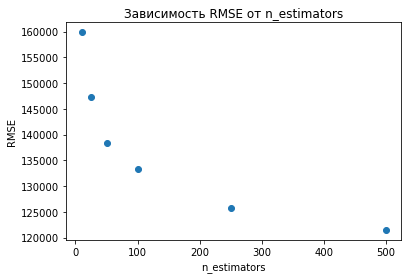

In [291]:
score = []
for i in range(len(n_grid)):
    gb_vals = four_d_rmse[i]
    gb_vals_score = np.ndarray.flatten(gb_vals)[np.array(sorted(np.argpartition(np.ndarray.flatten(gb_vals), 6)[:6]))].mean()
    score.append(gb_vals_score)
plt.title('Зависимость RMSE от n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.scatter(n_grid, np.array(score))
plt.savefig('RMSEn.pdf')
plt.show()

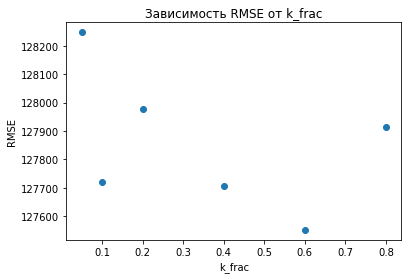

In [284]:
score = []
for i in range(len(depth_grid)):
    gb_vals = four_d_rmse[:, i]
    gb_vals_score = np.ndarray.flatten(gb_vals)[np.array(sorted(np.argpartition(np.ndarray.flatten(gb_vals), 6)[:6]))].mean()
    score.append(gb_vals_score)
plt.title('Зависимость RMSE от k_frac')
plt.xlabel('k_frac')
plt.ylabel('RMSE')
plt.scatter(k_grid, np.array(score))
plt.savefig('RMSEk.pdf')
plt.show()

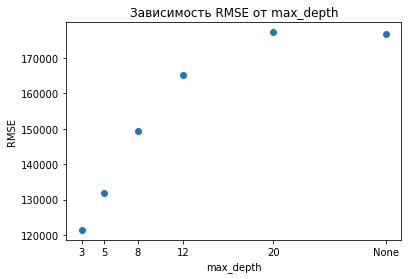

In [285]:
score = []
for i in range(len(n_grid)):
    gb_vals = four_d_rmse[:, :, i]
    gb_vals_score = np.ndarray.flatten(gb_vals)[np.array(sorted(np.argpartition(np.ndarray.flatten(gb_vals), 6)[:6]))].mean()
    score.append(gb_vals_score)
plt.title('Зависимость RMSE от max_depth')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
depth_grid_new = deepcopy(depth_grid)
depth_grid_new[5] = 30
plt.xticks(depth_grid_new, [3, 5, 8, 12, 20, 'None'])
plt.scatter(depth_grid_new, np.array(score))
plt.savefig('RMSEd.pdf')
plt.show()

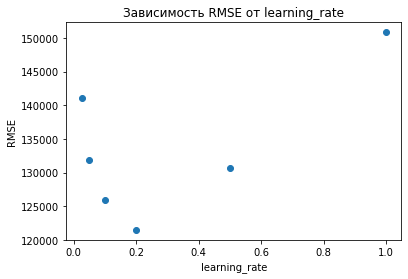

In [286]:
score = []
for i in range(len(learning_grid)):
    gb_vals = four_d_rmse[:, :, :, i]
    gb_vals_score = np.ndarray.flatten(gb_vals)[np.array(sorted(np.argpartition(np.ndarray.flatten(gb_vals), 6)[:6]))].mean()
    score.append(gb_vals_score)
plt.title('Зависимость RMSE от learning_rate')
plt.xlabel('learning_rate')
plt.ylabel('RMSE')
plt.scatter(learning_grid, np.array(score))
plt.savefig('RMSEl.pdf')
plt.show()

Последний опыт!!!

In [308]:
class MyDynamicGradBoost:
    
    def __init__(self, k_frac= 0.25, max_depth= 10, learning_rate= 0.1):
        self.n_estimators = 0
        self.k_frac = k_frac
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.models = []
        self.pred = 0
        self.rmse = 999999999
        self.d = 0
        
    def fit(self, X, y, D, X_test, y_test):
        # добавляет деревья, пока за последние d шагов есть хоть одно улучшение):
        self.models = []
        pred = []
        # init first predictor
        self.models.append(DecisionTreeRegressor(max_depth= self.max_depth))
        self.models[-1].fit(X, y)
        pred = self.models[-1].predict(X)
        while True:
            self.n_estimators += 1
            self.models.append(DecisionTreeRegressor(max_depth= self.max_depth))
            self.models[-1].fit(X, y - pred)
            pred += self.learning_rate * self.models[-1].predict(X)
            rmse = self.get_rmse(X_test, y_test)
            if rmse > self.rmse:
                self.d += 1
                if self.d >= D:
                    break
            else:
                self.d = 0
                self.rmse = rmse
        return self.n_estimators, self.rmse
    
    def predict(self, X):
        pred = self.models[0].predict(X)
        for t in range(1, self.n_estimators):
            pred += self.learning_rate * self.models[t].predict(X)
        return pred
    
    def get_rmse(self, X, y):
        return rmse(self.predict(X), y)

In [309]:
k_opt, d_opt, l_opt = 0.05, 3, 0.2

In [310]:
iter_num = 10

In [312]:
for i in range(iter_num):
    mdgb = MyDynamicGradBoost(k_opt, d_opt, l_opt)
    print(mdgb.fit(X_train, y_train, 25, X_test, y_test))

(475, 122221.1497061485)
(599, 120536.10176305597)
(475, 121830.03728474575)
(599, 120848.35133481488)
(599, 122955.27759128751)
(475, 123512.10680302116)
(475, 124048.39683690514)
(599, 120827.1094582944)
(576, 120983.62756542978)
(599, 121723.20980121363)


Best:

In [314]:
model = MyGradBoost(520, k_grid[0], depth_grid[0], learning_grid[3])
model.fit(X_train, y_train)

In [315]:
filename = 'grad_boost_best.sav'
pickle.dump(model, open(filename, 'wb'))